## Import packages

In [48]:
%%capture
import os
import sys

import numpy as np
import pandas as pd
import pandas_datareader.data as web

!pip install statsmodels==0.12.2
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

!pip install sktime==0.6.1
!pip install pmdarima==1.8.2
import lightgbm as lgb
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import (TransformedTargetForecaster,
                                        make_reduction)
from sktime.forecasting.model_selection import (ExpandingWindowSplitter,
                                                ForecastingGridSearchCV)
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

sns.set()
plt.style.use('bmh')

## ARIMA

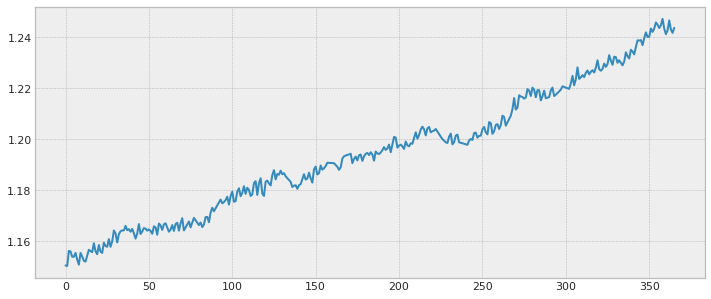

In [124]:
df = pd.read_csv('/content/drive/MyDrive/VDT2022/mini-project/stroke_recovery_dataset/protocol/sb01.csv')
cols = ['counts', 'speed']
data_df = df.loc[df.index, cols]
data_df = data_df.interpolate()
data = data_df['speed']

data.plot(figsize=(12, 5))
plt.show()

In [125]:
import warnings
warnings.filterwarnings("ignore")

def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

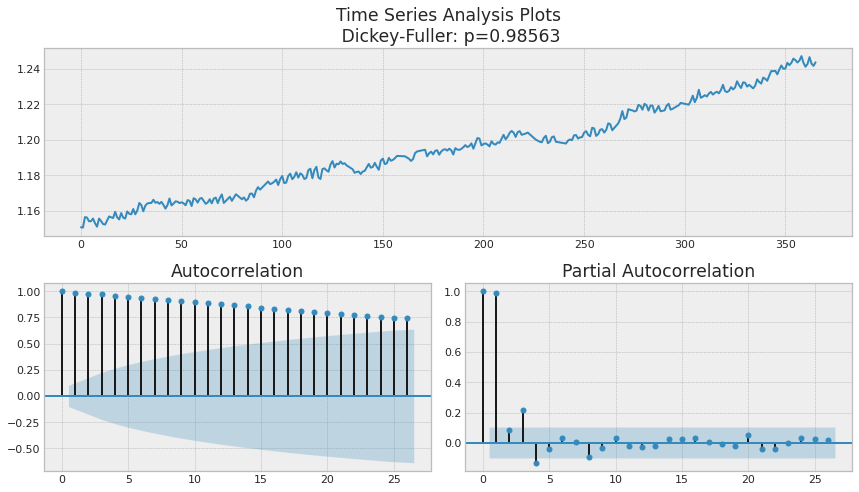

In [126]:
tsplot(data)

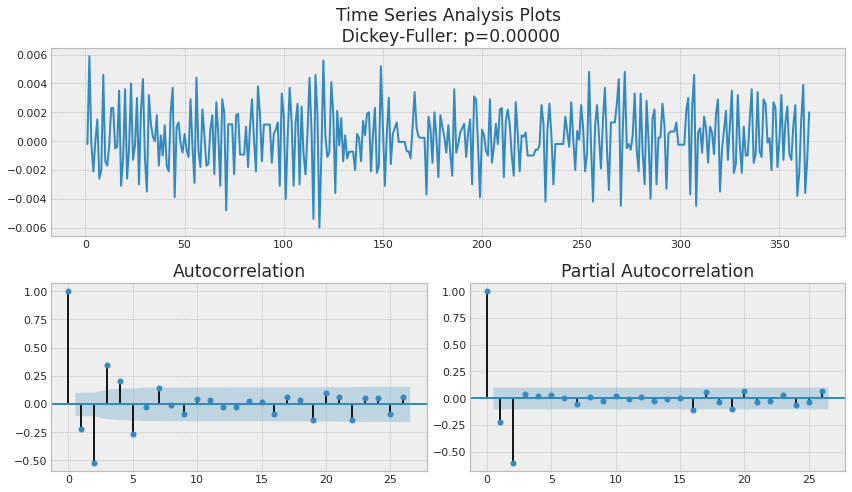

In [127]:
data_diff = (data - data.shift(1)).dropna()
tsplot(data_diff)

In [133]:
y = pd.Series(data_df.speed)
y.index = [i for i in range(366)]
y

0     1.151
1     1.150
2     1.156
3     1.156
4     1.154
       ... 
361   1.243
362   1.246
363   1.243
364   1.242
365   1.244
Name: speed, Length: 366, dtype: float64

In [134]:
test_len = 92
train_data, test_data = y.iloc[:-test_len], y.iloc[-test_len:]

In [135]:
forecaster = AutoARIMA(start_p=8, max_p=9, suppress_warnings=True)
forecaster.fit(train_data)
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  274
Model:               SARIMAX(2, 1, 0)   Log Likelihood                1361.216
Date:                Wed, 15 Jun 2022   AIC                          -2714.432
Time:                        12:42:23   BIC                          -2699.994
Sample:                             0   HQIC                         -2708.637
                                - 274                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.000      4.259      0.000       0.000       0.001
ar.L1         -0.3428      0.048     -7.118      0.000      -0.437      -0.248
ar.L2         -0.5939      0.049    -12.088      0.000      -0.690      -0.498
sigma2       2.72e-06   2.78e-07      9.777      0.000    2.17e-06    3.27e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 4.87
Prob(Q):                              0.82   Prob(JB):                         0.09
Heteroskedasticity (H):               1.01   Skew:                             0.17
Prob(H) (two-sided):                  0.95   Kurtosis:                         2.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [156]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

def plot_forecast(series_train, series_test, forecast, forecast_int=None):
    rmse = mean_squared_error(series_test, forecast)**0.5
    mae = mean_absolute_error(series_test, forecast)
    mape = mean_absolute_percentage_error(series_test, forecast)

    plt.figure(figsize=(12, 6))
    plt.title(f"RMSE: {rmse:.6f}, MAE: {mae:.6f}, MAPE: {mape:.6f}", size=18)
    series_train.plot(label="train", color="b")
    series_test.plot(label="test", color="g")
    forecast.index = series_test.index
    forecast.plot(label="forecast", color="r")
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.05,
            color="dimgray",
        )
    plt.legend(prop={"size": 16})
    plt.show()

    return rmse, mae, mape

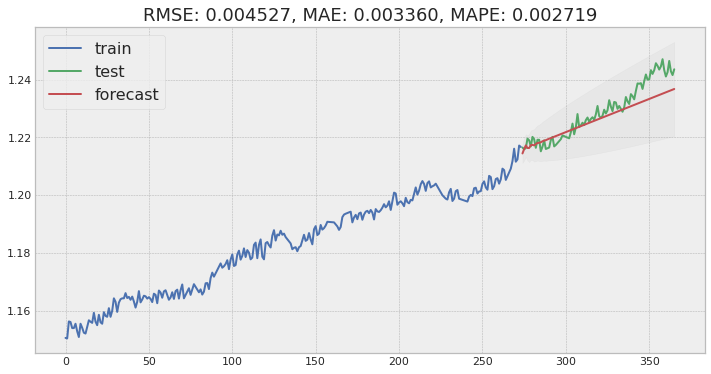

In [137]:
fh = np.arange(test_len) + 1
forecast, forecast_int = forecaster.predict(fh=fh, return_pred_int=True, alpha=0.05)
arima_rmse, arima_mae, arima_mape = plot_forecast(
    train_data, test_data, forecast, forecast_int
)

## LightGBM

In [157]:
def grid_serch_forecaster(train, test, forecaster, param_grid):

    # Grid search on window_length
    cv = ExpandingWindowSplitter(initial_window=int(len(train) * 0.7))
    gscv = ForecastingGridSearchCV(
        forecaster, strategy="refit", cv=cv, param_grid=param_grid
    )
    gscv.fit(train)
    print(f"best params: {gscv.best_params_}")

    # forecasting
    fh = np.arange(len(test)) + 1
    y_pred = gscv.predict(fh=fh)
    rmse, mae, mape = plot_forecast(train, test, y_pred)

    return rmse, mae, mape

In [158]:
def create_forecaster_w_desesonalizer(sp=3, degree=1):

    # creating forecaster with LightGBM
    regressor = lgb.LGBMRegressor()
    forecaster = TransformedTargetForecaster(
        [
            ("deseasonalize", Deseasonalizer(model="multiplicative", sp=sp)),
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=degree))),
            (
                "forecast",
                make_reduction(regressor, window_length=2, strategy="recursive"),
            ),
        ]
    )

    return forecaster

best params: {'forecast__window_length': 15}


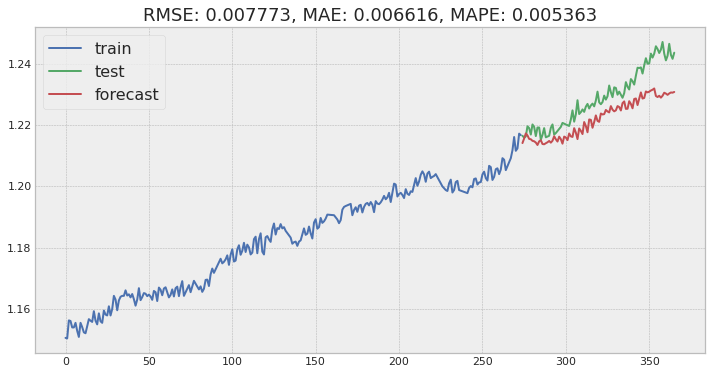

In [159]:
forecaster = create_forecaster_w_desesonalizer()
param_grid = {"forecast__window_length": [15]}

lgb_rmse, lgb_mae, lgb_mape = grid_serch_forecaster(
    train_data, test_data, forecaster, param_grid
)